# Implementing a ResNet-34 CNN Using PyTorch

In [2]:
import numpy as np
import torch
from sklearn.datasets import load_sample_images
import matplotlib.pyplot as plt
import torchvision
import torch.nn as nn
import torchvision.transforms.v2 as T
from functools import partial
import torchmetrics
import torch.nn.functional as F



### creating residual unit cllass for Resnet 

### ResidualUnit Architecture Diagram

```
                                INPUT
                                  |
                    ______________+______________
                   |                              |
                   |                              |
            MAIN PATH                      SKIP CONNECTION
                   |                              |
        Conv2d (stride=s)                   |-- Conv2d (1x1, stride=s)
        BatchNorm2d                         |   BatchNorm2d
        ReLU                                |-- Identity (if stride=1)
        Conv2d (stride=1)                   |
        BatchNorm2d                         |
                   |                              |
                   |____________+________________|
                              |
                           ADD (+)
                              |
                            ReLU
                              |
                           OUTPUT
```

**Data Flow:**
1. **Input** splits into two paths
2. **Main Path**: Two 3×3 convolutions with batch normalization and ReLU
3. **Skip Connection**: 
   - If stride > 1: 1×1 convolution (reduces spatial dimensions)
   - If stride = 1: Identity (passes input unchanged)
4. **Merge**: Add main path + skip connection outputs
5. **Activation**: Apply ReLU to the sum

In [3]:
class ResidualUnit(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        DefaultConv2d = partial(
            nn.Conv2d, kernel_size=3, stride=1, padding=1, bias=False)
        self.main_layers = nn.Sequential(
            DefaultConv2d(in_channels, out_channels, stride=stride),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            DefaultConv2d(out_channels, out_channels),
            nn.BatchNorm2d(out_channels),
        )
        if stride > 1:
            self.skip_connection = nn.Sequential(
                DefaultConv2d(in_channels, out_channels, kernel_size=1,
                              stride=stride, padding=0),
                nn.BatchNorm2d(out_channels),
            )
        else:
            self.skip_connection = nn.Identity()

    def forward(self, inputs):
        return F.relu(self.main_layers(inputs) + self.skip_connection(inputs))

### let’s build our ResNet34 module!

### ResNet34 Architecture Explanation

The `ResNet34` class builds a complete ResNet-34 network with 34 layers. Here's how it works:

**1. Stem (Initial Layers)**
- Conv2d: 3 channels → 64 filters, 7×7 kernel, stride 2 (downsamples image by 2×)
- BatchNorm2d + ReLU
- MaxPool2d: stride 2 (further downsampling)

**2. Residual Blocks (Core)**
The network adds ResidualUnits in 4 groups:
- **Group 1**: 3 units with 64 filters (stride=1, keeps spatial dims)
- **Group 2**: 4 units with 128 filters (first has stride=2 for downsampling, rest stride=1)
- **Group 3**: 6 units with 256 filters (first has stride=2, rest stride=1)
- **Group 4**: 3 units with 512 filters (first has stride=2, rest stride=1)

Total: 3 + 4 + 6 + 3 = **16 residual blocks** = 32 conv layers + 2 initial conv layers = **34 layers**

**Stride Logic**: 
- stride = 2 when filter count changes (reduces spatial resolution, increases channels)
- stride = 1 when filter count stays the same

**3. Classification Head**
- AdaptiveAvgPool2d: Global average pooling → (batch_size, 512, 1, 1)
- Flatten: → (batch_size, 512)
- LazyLinear: 512 → 10 classes

---

### ResNet34 Architecture Diagram

```
INPUT (3, 224, 224)
        ↓
┌─────────────────────────────────┐
│  Conv 7×7, 64, stride=2         │
│  BatchNorm + ReLU               │
│  MaxPool 3×3, stride=2          │
└─────────────────────────────────┘
        ↓ (64, 56, 56)
┌─────────────────────────────────┐
│  Stage 1: 3 × ResidualUnit(64)  │  stride=1
│  Filters: 64 → 64              │
└─────────────────────────────────┘
        ↓ (64, 56, 56)
┌─────────────────────────────────┐
│  Stage 2: 4 × ResidualUnit(128) │  first: stride=2, rest: stride=1
│  Filters: 64 → 128             │
└─────────────────────────────────┘
        ↓ (128, 28, 28)
┌─────────────────────────────────┐
│  Stage 3: 6 × ResidualUnit(256) │  first: stride=2, rest: stride=1
│  Filters: 128 → 256            │
└─────────────────────────────────┘
        ↓ (256, 14, 14)
┌─────────────────────────────────┐
│  Stage 4: 3 × ResidualUnit(512) │  first: stride=2, rest: stride=1
│  Filters: 256 → 512            │
└─────────────────────────────────┘
        ↓ (512, 7, 7)
┌─────────────────────────────────┐
│  AdaptiveAvgPool2d              │
│  Global Average Pooling         │
└─────────────────────────────────┘
        ↓ (512, 1, 1)
┌─────────────────────────────────┐
│  Flatten                        │
└─────────────────────────────────┘
        ↓ (512)
┌─────────────────────────────────┐
│  LazyLinear (512 → 10)          │
└─────────────────────────────────┘
        ↓
OUTPUT (10 classes)
```

**Key Design Points:**
- Progressively reduces spatial dimensions (56 → 28 → 14 → 7) while increasing channels
- Each stage transition uses stride=2 to halve dimensions
- Skip connections allow gradients to flow through all 34 layers
- Total parameters: ~23.5 million

In [4]:
class ResNet34(nn.Module):
    def __init__(self):
        super().__init__()
        layers = [
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2,
                      padding=3, bias=False),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        ]
        prev_filters = 64
        for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
            stride = 1 if filters == prev_filters else 2
            layers.append(ResidualUnit(prev_filters, filters, stride=stride))
            prev_filters = filters
        layers += [
            nn.AdaptiveAvgPool2d(output_size=1),
            nn.Flatten(),
            nn.LazyLinear(10),
        ]
        self.resnet = nn.Sequential(*layers)

    def forward(self, inputs):
        return self.resnet(inputs)

In [16]:
# Load CIFAR-10 Dataset
transform = T.Compose([
    T.ToImage(),
    T.ToDtype(torch.float32, scale=True),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load full training set
train_valid_dataset = torchvision.datasets.CIFAR10(root='./datasets', train=True, 
                                            download=False, transform=transform)
# Load test set for validation
test_dataset = torchvision.datasets.CIFAR10(root='./datasets', train=False, 
                                            download=False, transform=transform)

torch.manual_seed(42)
train_dataset, valid_dataset = torch.utils.data.random_split(
    train_valid_dataset, [45_000, 5_000]
)

# Create Data Loaders
batch_size = 128
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(
    dataset=valid_dataset, batch_size=batch_size, shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=False
)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(valid_dataset)}")
print(f"Testing  samples: {len(test_dataset)}")




/Users/nsharma14/Personal/NitinML/DeepLearningWithPyTorch/.venv/lib/python3.13/site-packages/torchvision/datasets/cifar.py:83: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  entry = pickle.load(f, encoding="latin1")


Training samples: 45000
Validation samples: 5000
Testing  samples: 10000


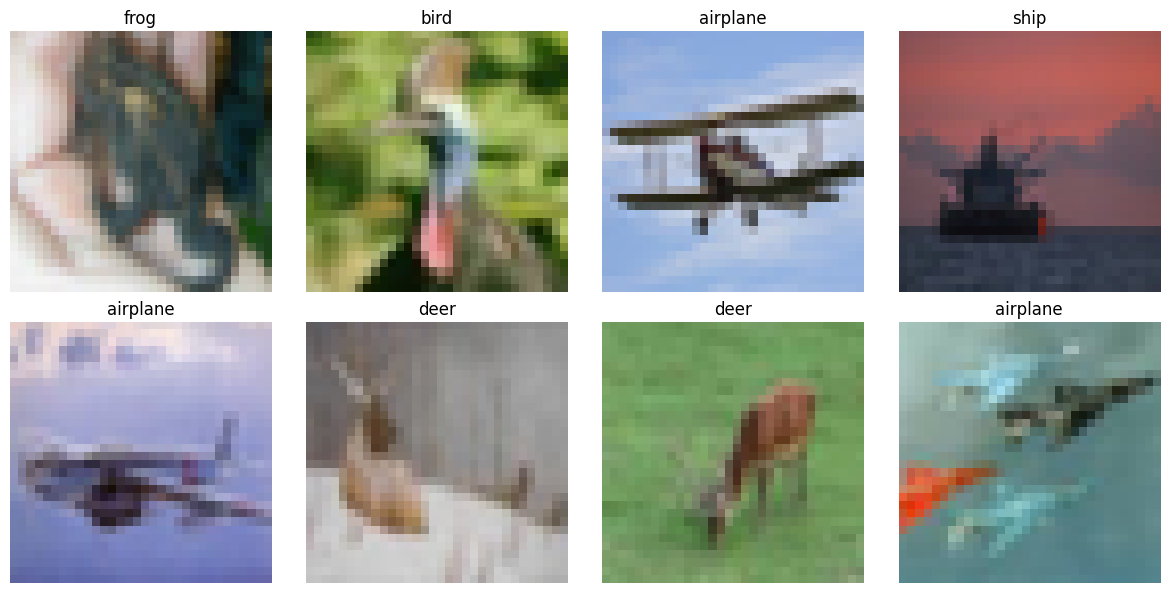

In [ ]:
# Visualize Sample Images
def show_sample_images(loader, dataset, num_images=8):
    """Display sample images from the dataset"""
    images, labels = next(iter(loader))
    
    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    axes = axes.flatten()
    
    # Denormalize for visualization
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
    images_denorm = (images * std + mean).clamp(0, 1)
    
    for idx, ax in enumerate(axes):
        if idx < num_images:
            img = images_denorm[idx].permute(1, 2, 0).numpy()
            label = dataset.classes[labels[idx]]
            ax.imshow(img)
            ax.set_title(label)
            ax.axis('off')
        else:
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Display samples
show_sample_images(train_loader, train_dataset, num_images=8)

In [7]:
# Setup for Training
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize model
model = ResNet34().to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)




Using device: mps


In [17]:
# Training function
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    avg_loss = total_loss / len(train_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy


In [18]:
# Testing function
def test_epoch(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_loss = total_loss / len(test_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

#print(f"Model created with {sum(p.numel() for p in model.parameters()):,} parameters")
print("Ready to train!")

Ready to train!


In [22]:
# Train for 10 epochs
num_epochs = 10
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

print("Starting training for 10 epochs...")
print("=" * 80)

for epoch in range(num_epochs):
    # Train for one epoch
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Validate for one epoch
    valid_loss, valid_acc = test_epoch(model, valid_loader, criterion, device)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    # Print results for each epoch
    print(f"Epoch [{epoch+1:2d}/{num_epochs}] | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:6.2f}% | "
          f"Valid Loss: {valid_loss:.4f} | Valid Acc: {valid_acc:6.2f}%")

print("=" * 80) 
print("Training completed!")

print("Model saved to './my_resnet34_checkpoint.pt'")

# Save the trained modeltorch.save(model.state_dict(), './my_resnet34_checkpoint.pt')

Starting training for 10 epochs...
Epoch [ 1/10] | Train Loss: 0.1853 | Train Acc:  93.58% | Valid Loss: 0.6287 | Valid Acc:  82.22%
Epoch [ 2/10] | Train Loss: 0.1498 | Train Acc:  94.80% | Valid Loss: 0.7269 | Valid Acc:  80.48%
Epoch [ 3/10] | Train Loss: 0.1282 | Train Acc:  95.52% | Valid Loss: 0.7559 | Valid Acc:  80.24%
Epoch [ 4/10] | Train Loss: 0.0961 | Train Acc:  96.71% | Valid Loss: 0.8131 | Valid Acc:  80.16%
Epoch [ 5/10] | Train Loss: 0.0948 | Train Acc:  96.57% | Valid Loss: 0.8196 | Valid Acc:  80.94%
Epoch [ 6/10] | Train Loss: 0.0853 | Train Acc:  97.06% | Valid Loss: 0.8924 | Valid Acc:  79.26%
Epoch [ 7/10] | Train Loss: 0.0755 | Train Acc:  97.44% | Valid Loss: 0.8582 | Valid Acc:  80.14%
Epoch [ 8/10] | Train Loss: 0.0661 | Train Acc:  97.79% | Valid Loss: 0.9182 | Valid Acc:  80.18%
Epoch [ 9/10] | Train Loss: 0.0653 | Train Acc:  97.71% | Valid Loss: 0.9218 | Valid Acc:  80.42%
Epoch [10/10] | Train Loss: 0.0518 | Train Acc:  98.22% | Valid Loss: 0.9642 | Vali

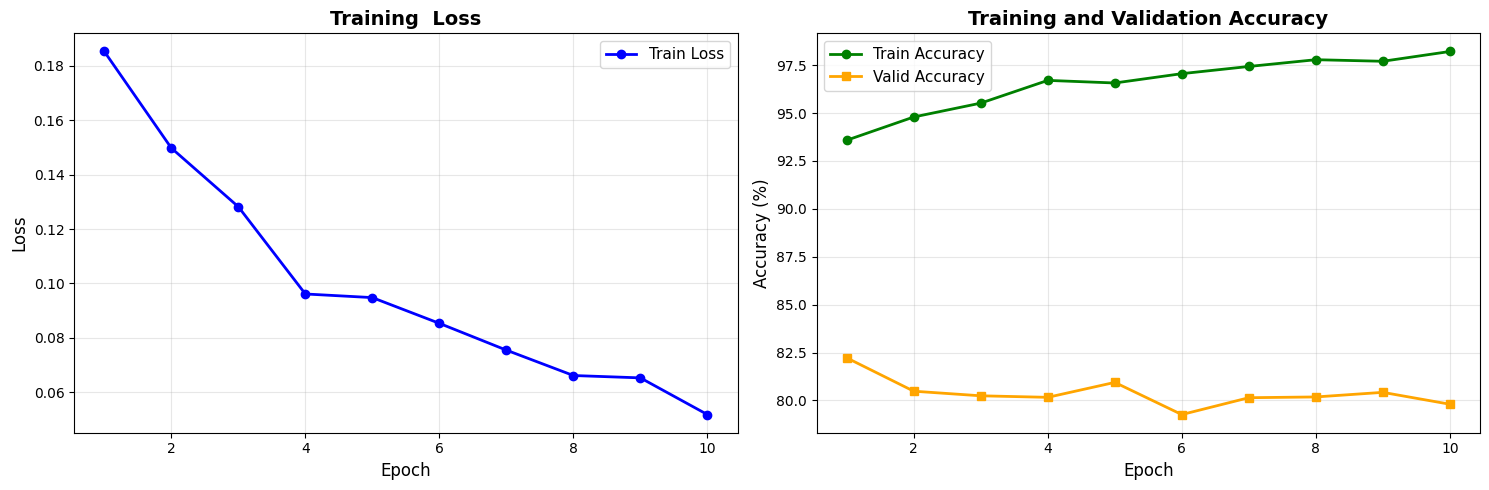


TRAINING SUMMARY
Total Epochs Trained: 10

Final Metrics:
  Train Loss: 0.0518
  Train Accuracy: 98.22%
  Valid Loss: 0.9642
  Valid Accuracy: 79.80%

Best Validation Metrics:
  Best Valid Accuracy: 82.22% (Epoch 1)
  Best Valid Loss: 0.6287 (Epoch 1)


In [ ]:
# Plot Training, Validation, and Test Metrics
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
epochs_range = range(1, len(train_losses) + 1)
axes[0].plot(epochs_range, train_losses, 'b-', linewidth=2, label='Train Loss', marker='o')
axes[0].plot(epochs_range, valid_losses, 'r-', linewidth=2, label='Valid Loss', marker='s')
axes[0].axhline(y=test_loss, color='g', linestyle='--', linewidth=2, label=f'Test Loss ({test_loss:.4f})')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training, Validation, and Test Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(epochs_range, train_accs, 'b-', linewidth=2, label='Train Accuracy', marker='o')
axes[1].plot(epochs_range, valid_accs, 'r-', linewidth=2, label='Valid Accuracy', marker='s')
axes[1].axhline(y=test_acc, color='g', linestyle='--', linewidth=2, label=f'Test Accuracy ({test_acc:.2f}%)')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Training, Validation, and Test Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*70)
print("TRAINING SUMMARY")
print("="*70)
print(f"Total Epochs Trained: {len(train_losses)}")
print(f"\nFinal Training Metrics:")
print(f"  Train Loss: {train_losses[-1]:.4f}")
print(f"  Train Accuracy: {train_accs[-1]:.2f}%")
print(f"\nFinal Validation Metrics:")
print(f"  Valid Loss: {valid_losses[-1]:.4f}")
print(f"  Valid Accuracy: {valid_accs[-1]:.2f}%")
print(f"\nTest Metrics (on unseen data):")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  Test Accuracy: {test_acc:.2f}%")
print(f"\nBest Validation Metrics:")
print(f"  Best Valid Accuracy: {max(valid_accs):.2f}% (Epoch {valid_accs.index(max(valid_accs)) + 1})")
print(f"  Best Valid Loss: {min(valid_losses):.4f} (Epoch {valid_losses.index(min(valid_losses)) + 1})")
print(f"\nModel Performance Comparison:")
print(f"  Train-Test Accuracy Gap: {train_accs[-1] - test_acc:.2f}%")
print(f"  Valid-Test Accuracy Gap: {valid_accs[-1] - test_acc:.2f}%")
print("="*70)

In [24]:
# Evaluate on Test Data
print("Evaluating model on test data...")
test_loss, test_acc = test_epoch(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")

Evaluating model on test data...
Test Loss: 1.2146
Test Accuracy: 76.64%
